#### Torch CNN - CIFAR10

In [7]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from models import CNN

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [18]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
        
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/FISTA_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [16]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [26]:
import time
from optim.fista import FISTA, soft_thresholding
from models import SimpleCNN

def modeling(n_epochs=100, lr=0.01, threshold=90):
    print("="*50, f"\nEpochs: {n_epochs}, LR: {lr}, Threshold: {threshold}", "\n"+"="*50)
    LAMBDA_L1 = 0.001
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    def fista_prox_op(x, lr):
        return soft_thresholding(x, threshold=lr * LAMBDA_L1)
    optimizer = FISTA(model.parameters(), lr=STEP_SIZE, prox_op=fista_prox_op)
    
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for epoch in range(n_epochs):
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        run_time = time.time() - _start
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 2 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

Epochs: 40, LR: 0.001, Threshold: 58 
E [1/40]. train_loss_acc: 1.9543, 29.62%, test_acc: 43.58%, run_time: 7.885647535324097
E [3/40]. train_loss_acc: 1.4892, 45.03%, test_acc: 48.87%, run_time: 7.878436088562012
E [5/40]. train_loss_acc: 1.3544, 50.39%, test_acc: 53.31%, run_time: 7.870041370391846
E [7/40]. train_loss_acc: 1.3136, 52.34%, test_acc: 56.60%, run_time: 7.8562469482421875
E [9/40]. train_loss_acc: 1.2648, 54.26%, test_acc: 56.42%, run_time: 7.859420299530029
E [11/40]. train_loss_acc: 1.2235, 56.26%, test_acc: 59.82%, run_time: 7.872209548950195
E [13/40]. train_loss_acc: 1.2044, 57.09%, test_acc: 61.67%, run_time: 7.869256973266602
E [15/40]. train_loss_acc: 1.2250, 56.18%, test_acc: 59.51%, run_time: 7.877714157104492
E [17/40]. train_loss_acc: 1.2361, 55.63%, test_acc: 61.08%, run_time: 7.878068447113037
E [19/40]. train_loss_acc: 1.2651, 54.86%, test_acc: 60.34%, run_time: 7.876404523849487
E [21/40]. train_loss_acc: 1.2292, 55.36%, test_acc: 59.37%, run_time: 7.877

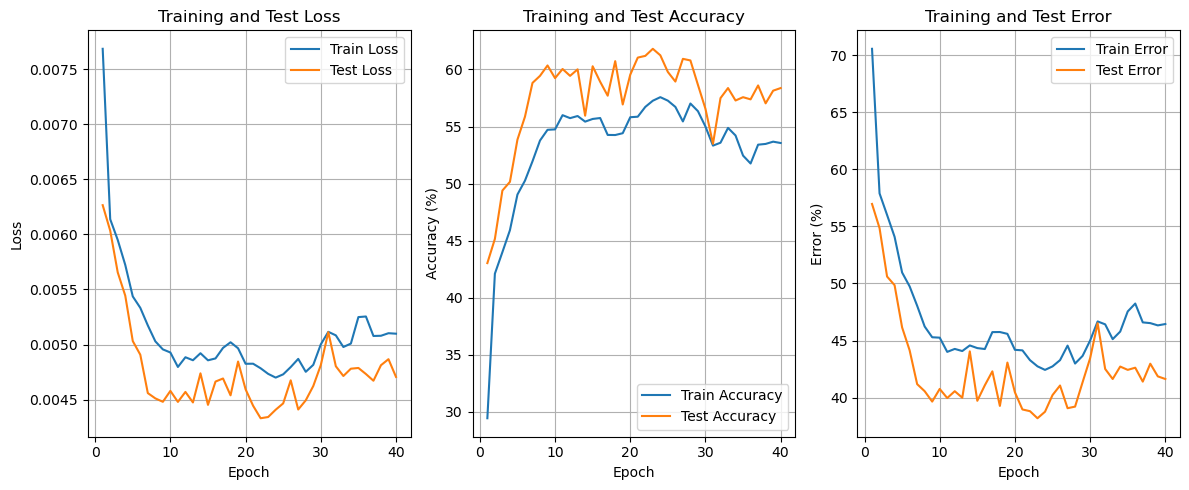

In [27]:
import numpy as np
from plot import metrics_plot

n_epochs = 40
threshold = 58
lrs = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1,]

for lr in lrs: 
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                             lr=lr,
                                                                                              threshold=threshold,
                                                                                             )
    save_path = f'scores/FISTA/E{n_epochs}T{threshold}'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [28]:
import os, json

def viz_scores(scores_path, threshold):
    contents = os.walk(scores_path)
    lr_runtime, lr_epochs, runtimes, epochs, lrs = {}, {}, [], [], []
    train_loss_dict = {}
    train_acc_dict = {}

    for root, dirs, files in contents:
        for f in files:
            if f.startswith("FISTA_lr"):
                _path = os.path.join(root, f)
                with open(_path, 'r') as file:
                    data = json.load(file)
                lrs.append(data['n_step'])
                runtimes.append(sum(data['run_time']))
                epochs.append(len(data['run_time']))

                train_loss_dict[data['n_step']] = data['train_losses']
                train_acc_dict[data['n_step']] = data['train_accs']
    lr_runtime['lr'] = lrs
    lr_runtime['run_time'] = runtimes
    lr_epochs['lr'] = lrs
    lr_epochs['nepochs'] = epochs

    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(lr_runtime['lr'], lr_runtime['run_time'], label='Runtime', marker='o',linestyle='', color='blue', alpha=.5)
    ax2.plot(lr_epochs['lr'], lr_epochs['nepochs'], label='Epochs', marker='o', linestyle='', color='red', alpha=.5)

    ax1.set_ylabel('Runtime (s)')
    ax2.set_ylabel('Epochs')

    ax1.set_xlabel('Stepsize')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.title(f'Step size evaluation to get {threshold}% train acc')
    plt.grid(True)
    plt.show()
    return train_loss_dict, train_acc_dict

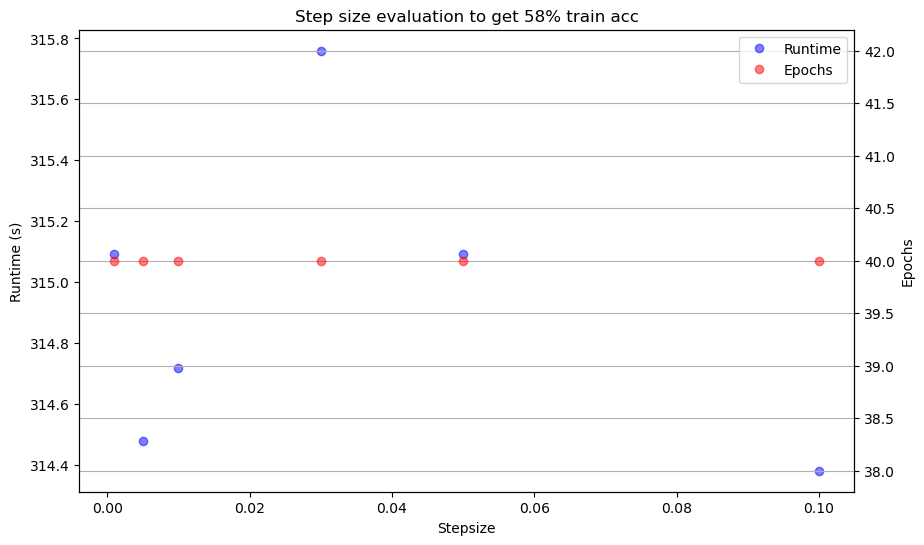

In [32]:
scores_path_1 = "scores/FISTA/E40T58"
train_loss_dict_1, train_acc_dict_1 = viz_scores(scores_path_1, threshold=58)
